In [1]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold 
from sklearn.model_selection import StratifiedKFold 
from sklearn.model_selection import KFold
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn import metrics
from matplotlib import ticker

In [2]:
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option("max_columns", 100)

In [3]:
combined = pd.read_csv("data/combined1.csv")

In [13]:
from imblearn import under_sampling
from imblearn import over_sampling
from imblearn.over_sampling import SMOTE
from collections import Counter

In [9]:
oversample = SMOTE()

In [7]:
y = combined['callback']
X = combined.drop(['callback'], axis=1)


In [10]:
X, y = oversample.fit_resample(X,y)

In [14]:
counter = Counter(y)
for k, v in counter.items():
    dist = v / len(y) * 100
    print(f"Class = {k}, n ={v} ({dist}%)")

Class = 0.0, n =11612 (50.0%)
Class = 1.0, n =11612 (50.0%)


## Preprocessing Data - Combined Data ##

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)

In [16]:
kfold = KFold(n_splits=5)
skfold = StratifiedKFold(n_splits=5, shuffle=True)
rkf = RepeatedKFold(n_splits=5, n_repeats=10)

In [17]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Testing Data  - Penalized Logistic Regression ##

In [18]:
from sklearn.linear_model import LogisticRegression
logreg_scaled = LogisticRegression(C = 10, penalty = 'l1', solver = 'liblinear').fit(X_train_scaled, y_train)

print("PENALIZED LOGISTIC REGRESSION (SCALED DATA)")
print("Training set score: {:.2f}".format(logreg_scaled.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(logreg_scaled.score(X_test_scaled, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(logreg_scaled, 
                                                                             X_train_scaled, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))


logreg_scaled_coef = pd.DataFrame(data=logreg_scaled.coef_, 
                                  columns=X.columns, 
                                  index=['Penalized Scaled Logistic Regression Coefficients'])

yhat = logreg_scaled.predict(X_test_scaled)
c2 = [logreg_scaled_coef]
coefs = pd.concat(c2)
coefs.T.sort_values(by = 'Penalized Scaled Logistic Regression Coefficients', ascending=False)

/Users/andrewlai/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


PENALIZED LOGISTIC REGRESSION (SCALED DATA)
Training set score: 0.65
Test set score: 0.65


/Users/andrewlai/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Mean Cross Validation, SKFold: 0.65


,Penalized Scaled Logistic Regression Coefficients
skillspeaking,0.135238
female,0.107900
language_skills,0.016261
skillsocialper,-0.024033
accreditation,-0.182366
reference,-0.213271
anglo,-0.858362
east_asian,-1.075266
south_asian,-1.088407
montreal,-3.112945


<AxesSubplot:title={'center':'Feature Importance (Logistic Regression)'}>

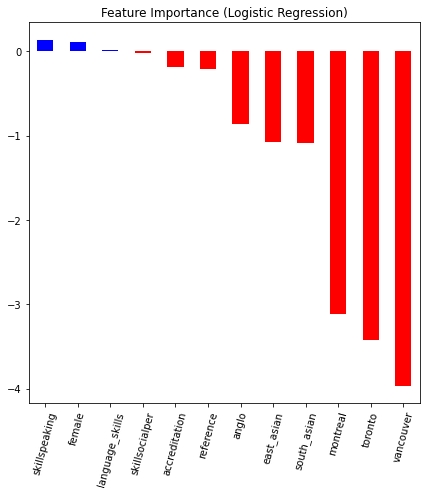

In [19]:
graph = coefs.T.sort_values(by = 'Penalized Scaled Logistic Regression Coefficients', ascending=False)
graph['Penalized Scaled Logistic Regression Coefficients'].plot.bar(
    title = 'Feature Importance (Logistic Regression)',
    legend = False, 
    figsize = (7,7),
    rot = 75,
    color=(graph['Penalized Scaled Logistic Regression Coefficients'] > 0).map({True: 'b', False: 'red'}))

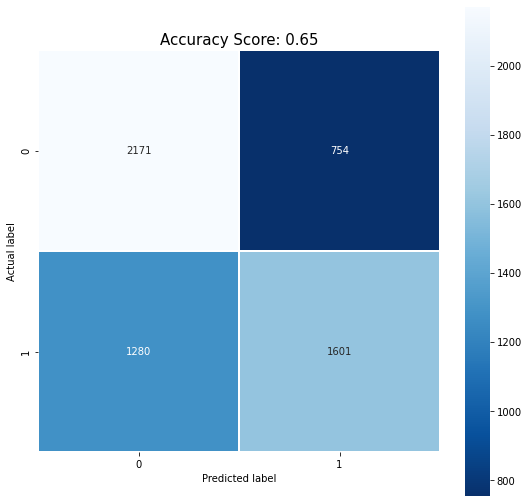

In [20]:
cm = metrics.confusion_matrix(y_test, yhat)
plt.figure(figsize=(9,9))
score = (logreg_scaled.score(X_test_scaled, y_test))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);

In [21]:
from sklearn.metrics import classification_report
target_names = ['class 0', 'class 1']
print(classification_report(y_test, yhat, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.63      0.74      0.68      2925
     class 1       0.68      0.56      0.61      2881

    accuracy                           0.65      5806
   macro avg       0.65      0.65      0.65      5806
weighted avg       0.65      0.65      0.65      5806



## Testing Data - Random Forest  ##

In [22]:
from sklearn.ensemble import RandomForestClassifier
rforest = RandomForestClassifier(n_estimators=200)
rforest.fit(X_train_scaled,y_train)
ypred = rforest.predict(X_test_scaled)

In [23]:
print("RANDOM FORESST (SCALED DATA)")
print("Training set score: {:.2f}".format(rforest.score(X_train_scaled, y_train)))
print("Test set score: {:.2f}".format(rforest.score(X_test_scaled, y_test)))

print("Mean Cross Validation, SKFold: {:.2f}".format(np.mean(cross_val_score(rforest, 
                                                                             X_train_scaled, 
                                                                             y_train, 
                                                                             cv=skfold,
                                                                            scoring = 'accuracy'))))

rforest_feature = pd.DataFrame(data=rforest.feature_importances_).T
rforest_feature.columns = X.columns
rforest_feature.index=['Random Forest Features']


rforest_feature.T.sort_values(by = 'Random Forest Features', ascending=False)

RANDOM FORESST (SCALED DATA)
Training set score: 0.85
Test set score: 0.83
Mean Cross Validation, SKFold: 0.82


,Random Forest Features
skillspeaking,0.224428
skillsocialper,0.190428
female,0.164067
language_skills,0.130717
toronto,0.049550
south_asian,0.049397
east_asian,0.048152
vancouver,0.043678
anglo,0.040258
montreal,0.038554


<AxesSubplot:title={'center':'Feature Importance (Random Forest)'}>

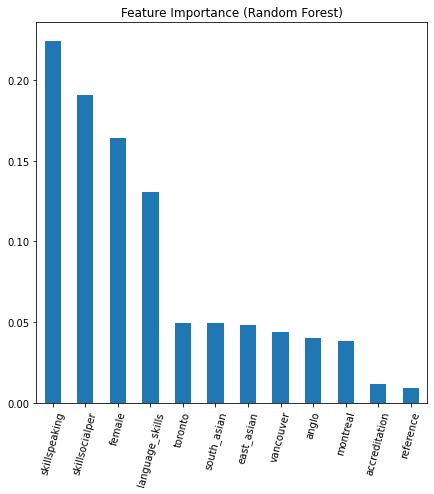

In [24]:
rf_graph = rforest_feature.T.sort_values(by = 'Random Forest Features', ascending=False)
rf_graph['Random Forest Features'].plot.bar(
    title = 'Feature Importance (Random Forest)',
    legend = False, 
    figsize = (7,7),
    rot = 75)

In [25]:
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

         0.0       0.82      0.84      0.83      2856
         1.0       0.84      0.82      0.83      2950

    accuracy                           0.83      5806
   macro avg       0.83      0.83      0.83      5806
weighted avg       0.83      0.83      0.83      5806



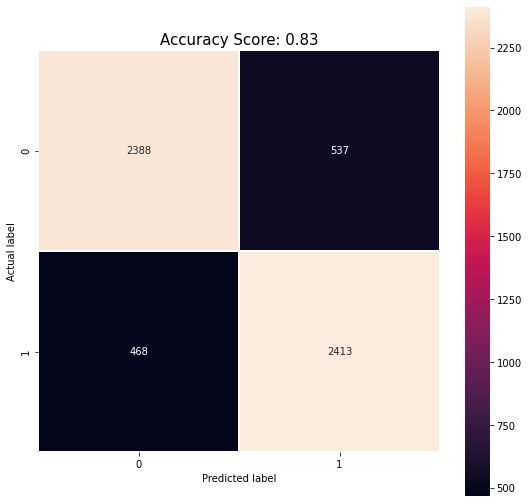

In [26]:
rf_mat = metrics.confusion_matrix(y_test, ypred)
plt.figure(figsize=(9,9))
score = (rforest.score(X_test_scaled, y_test))
sns.heatmap(rf_mat, annot=True, fmt=".0f", linewidths=.5, square = True);
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(round(score, 2))
plt.title(all_sample_title, size = 15);